In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!pip install lightning transformers rouge-score

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 47.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.0/7.0 MB 105.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 69.7/69.7 kB 9.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 66.9/66.9 kB 7.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.3/58.3 kB 6.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 55.5/55.5 kB 7.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 719.0/719.0 kB 60.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 66.4/66.4 kB 6.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 519.2/519.2 kB 50.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.9/129.9 kB 17.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 557.1/557.1 kB

# Import library and preprocessing data

## Import library

In [ ]:
import json
import pandas as pd
import numpy as np
import lightning as pl
from sklearn.model_selection import train_test_split

In [ ]:
from torch.utils.data import Dataset, DataLoader
from lightning.pytorch import Trainer
from lightning.pytorch.callbacks import ModelCheckpoint, EarlyStopping

from lightning.pytorch.loggers import TensorBoardLogger
from transformers import AdamW, T5ForConditionalGeneration, T5TokenizerFast as T5Tokenizer, BartForConditionalGeneration, BartTokenizerFast as BartTokenizer
from tqdm.auto import tqdm

## Read data

In [ ]:
dirpath = '/content/drive/MyDrive/Natural Language Processing/52000734_52000761_52000768/'

In [ ]:
pl.seed_everything(1234)

INFO: Global seed set to 1234
INFO:lightning.fabric.utilities.seed:Global seed set to 1234


1234

In [ ]:
df = pd.read_csv(f"{dirpath}/news_summary_more.csv", encoding="utf-8")
df.head()

,headlines,text
0,upGrad learner switches to career in ML & Al w...,"Saurav Kant, an alumnus of upGrad and IIIT-B's..."
1,Delhi techie wins free food from Swiggy for on...,Kunal Shah's credit card bill payment platform...
2,New Zealand end Rohit Sharma-led India's 12-ma...,New Zealand defeated India by 8 wickets in the...
3,Aegon life iTerm insurance plan helps customer...,"With Aegon Life iTerm Insurance plan, customer..."
4,"Have known Hirani for yrs, what if MeToo claim...",Speaking about the sexual harassment allegatio...


In [ ]:
df = df[['headlines', 'text']]
df.head()

,headlines,text
0,upGrad learner switches to career in ML & Al w...,"Saurav Kant, an alumnus of upGrad and IIIT-B's..."
1,Delhi techie wins free food from Swiggy for on...,Kunal Shah's credit card bill payment platform...
2,New Zealand end Rohit Sharma-led India's 12-ma...,New Zealand defeated India by 8 wickets in the...
3,Aegon life iTerm insurance plan helps customer...,"With Aegon Life iTerm Insurance plan, customer..."
4,"Have known Hirani for yrs, what if MeToo claim...",Speaking about the sexual harassment allegatio...


In [ ]:
df.columns = ['summary', 'text']
df = df.dropna()
df.head()

,summary,text
0,upGrad learner switches to career in ML & Al w...,"Saurav Kant, an alumnus of upGrad and IIIT-B's..."
1,Delhi techie wins free food from Swiggy for on...,Kunal Shah's credit card bill payment platform...
2,New Zealand end Rohit Sharma-led India's 12-ma...,New Zealand defeated India by 8 wickets in the...
3,Aegon life iTerm insurance plan helps customer...,"With Aegon Life iTerm Insurance plan, customer..."
4,"Have known Hirani for yrs, what if MeToo claim...",Speaking about the sexual harassment allegatio...


In [ ]:
df.shape

(98401, 2)

## Split data

In [ ]:
train_size = int(0.8 * len(df))
val_size = int(0.1 * len(df))
test_size = len(df) - train_size - val_size

In [ ]:
data_train = df.iloc[:train_size, :]
data_val = df.iloc[train_size:train_size+val_size, :]
data_test = df.iloc[train_size+val_size:, :]

In [ ]:
print(f"Shape of the Train Set: {data_train.shape}\nShape of the Val Set: {data_val.shape}\n Shape of the Test Set{data_test.shape}")

Shape of the Train Set: (78720, 2)
Shape of the Val Set: (9840, 2)
 Shape of the Test Set(9841, 2)


In [ ]:
summary_max_token_len = df['summary'].apply(lambda x: len(x.split())).max()
text_max_token_len = df['text'].apply(lambda x: len(x.split())).max()

In [ ]:
text_max_token_len

66

## Tokenizer data

In [ ]:
class NewsDataset(Dataset):
    def __init__(self, data, tokenizer, text_max_token_len=text_max_token_len, summary_max_token_len=summary_max_token_len):
        """
        A dataset that represents news articles and their respective summaries.

        Args:
        - data (pd.DataFrame): The data that contains the news articles and their summaries.
        - tokenizer (transformers.tokenization_*) : The tokenizer used to tokenize the text and summary.
        - text_max_token_len (int, optional): The maximum length of the text in terms of tokens. Defaults to 512.
        - summary_max_token_len (int, optional): The maximum length of the summary in terms of tokens. Defaults to 128.
        """
        self.tokenizer = tokenizer
        self.data = data
        self.text_max_token_len = text_max_token_len
        self.summary_max_token_len = summary_max_token_len
        
    def __len__(self):
        """
        Returns:
        - The number of samples in the dataset.
        """
        return len(self.data)
    
    def __getitem__(self, index):
        """
        Get a sample from the dataset.

        Args:
        - index (int): The index of the sample to get.

        Returns:
        - A dictionary that contains the following:
            - text (str): The original text of the news article.
            - summary (str): The summary of the news article.
            - input_ids (torch.Tensor): The input IDs of the text after tokenization.
            - attention_mask (torch.Tensor): The attention mask of the text after tokenization.
            - labels (torch.Tensor): The input IDs of the summary after tokenization.
            - decoder_attention_mask (torch.Tensor): The attention mask of the summary after tokenization.
        """
        data_row = self.data.iloc[index]
        text = data_row["text"]

        # Encode the text
        text_encoding = self.tokenizer(
            text, 
            max_length=self.text_max_token_len,
            padding="max_length",
            truncation=True,
            return_attention_mask=True,
            add_special_tokens=True,
            return_tensors="pt"
        )

        # Encode the summary
        summary_encoding = self.tokenizer(
            data_row["summary"], 
            max_length=self.summary_max_token_len,
            padding="max_length",
            truncation=True,
            return_attention_mask=True,
            add_special_tokens=True,
            return_tensors="pt"
        )

        # Modify the labels so that the model knows which tokens to predict
        labels = summary_encoding['input_ids']
        labels[labels == 0] = -100
        
        return {
            'text': text,
            'summary': data_row['summary'],
            'input_ids': text_encoding['input_ids'].flatten(),
            'attention_mask': text_encoding['attention_mask'].flatten(),
            'labels': labels.flatten(),
            'decoder_attention_mask': summary_encoding["attention_mask"].flatten()
        }

## Processing data --> Dataloader (Train, validation, test)

In [ ]:
class NewsDataModule(pl.LightningDataModule):
    def __init__(self,
                 train_df,
                 val_df,
                 tokenizer,
                 batch_size=16,
                 text_max_token_len=text_max_token_len,
                 summary_max_token_len=summary_max_token_len):
        """
        Initializes the NewsDataModule.
        
        Args:
        - train_df (pandas.DataFrame): the training dataset
        - val_df (pandas.DataFrame): the validating dataset
        - tokenizer (transformers.PreTrainedTokenizer): the tokenizer to be used
        - batch_size (int): the batch size
        - text_max_token_len (int): the maximum number of tokens for the text
        - summary_max_token_len (int): the maximum number of tokens for the summary
        """
        super().__init__()
        
        self.train_df = train_df
        self.val_df = val_df
        
        self.batch_size = batch_size
        self.tokenizer = tokenizer
        self.text_max_token_len = text_max_token_len
        self.summary_max_token_len = summary_max_token_len
    
    def setup(self, stage=None):
        """
        Sets up the dataset.
        """
        self.train_dataset = NewsDataset(
            self.train_df,
            self.tokenizer,
            self.text_max_token_len,
            self.summary_max_token_len)
        
        self.val_dataset = NewsDataset(
            self.val_df,
            self.tokenizer,
            self.text_max_token_len,
            self.summary_max_token_len)
    
    def train_dataloader(self):
        """
        Returns the DataLoader for the training set.
        """
        return DataLoader(
            self.train_dataset,
            batch_size=self.batch_size,
            shuffle=True
        )
    
    def test_dataloader(self):
        """
        Returns the DataLoader for the testing set.
        """
        return DataLoader(
            self.test_dataset,
            batch_size=self.batch_size,
            shuffle=False
        )
    
    def val_dataloader(self):
        """
        Returns the DataLoader for the validation set, which is the same as the testing set.
        """
        return DataLoader(
            self.val_dataset,
            batch_size=self.batch_size,
            shuffle=False
        )

In [ ]:
def getTestDataloader(data, tokenizer, batch_size=16, text_max_token_len=text_max_token_len, summary_max_token_len=summary_max_token_len):
  data_tmp = NewsDataset(
      data, tokenizer, text_max_token_len, summary_max_token_len
  )
  return DataLoader(
      data_tmp,
      batch_size=batch_size,
      shuffle=False
  )

## Get tokenizer from pre-trained (Transformer)

In [ ]:
BART_MODEL = 'facebook/bart-base'
T5_MODEL = 't5-base'
T5tokenizer = T5Tokenizer.from_pretrained(T5_MODEL)
Barttokenizer = BartTokenizer.from_pretrained(BART_MODEL)

/usr/local/lib/python3.9/dist-packages/transformers/models/t5/tokenization_t5_fast.py:155: FutureWarning: This tokenizer was incorrectly instantiated with a model max length of 512 which will be corrected in Transformers v5.
For now, this behavior is kept to avoid breaking backwards compatibility when padding/encoding with `truncation is True`.
- Be aware that you SHOULD NOT rely on t5-base automatically truncating your input to 512 when padding/encoding.
- If you want to encode/pad to sequences longer than 512 you can either instantiate this tokenizer with `model_max_length` or pass `max_length` when encoding/padding.
- To avoid this warning, please instantiate this tokenizer with `model_max_length` set to your preferred value.
  warnings.warn(


In [ ]:
N_EPOCHS = 5
BATCH_SIZE= 16

data_loader_T5_test = getTestDataloader(data_test, T5tokenizer)

data_loader_Bart_test = getTestDataloader(data_test, Barttokenizer)

data_module_T5 = NewsDataModule(
    data_train, 
    data_test,
    T5tokenizer,
    batch_size=BATCH_SIZE
    
)

data_module_Bart = NewsDataModule(
    data_train, 
    data_test,
    Barttokenizer,
    batch_size=BATCH_SIZE
    
)

# MODEL

---



1.   T5-base

2.   Bart-base



In [ ]:
class SummaryModel(pl.LightningModule):
    def __init__(self, model, model_name):
        super().__init__()
        self.save_hyperparameters()
        self.model = model.from_pretrained(model_name, return_dict=True)

    def forward(self, input_ids, attention_mask, decoder_attention_mask, labels=None):
        output = self.model(
            input_ids,
            attention_mask=attention_mask,
            labels=labels,
            decoder_attention_mask=decoder_attention_mask
        )
        return output.loss, output.logits

    def shared_step(self, batch, batch_idx, stage):
        input_ids = batch['input_ids']
        attention_mask = batch["attention_mask"]
        labels = batch["labels"]
        decoder_attention_mask = batch["decoder_attention_mask"]

        loss, _ = self(
            input_ids=input_ids,
            attention_mask=attention_mask,
            decoder_attention_mask=decoder_attention_mask,
            labels=labels
        )
        self.log(f"{stage}_loss", loss, prog_bar=True, logger=True)
        return loss
        
    def training_step(self, batch, batch_idx):
        return self.shared_step(batch, batch_idx, 'train')

    def validation_step(self, batch, batch_idx):
        return self.shared_step(batch, batch_idx, 'val')

    def test_step(self, batch, batch_idx):
        return self.shared_step(batch, batch_idx, 'test')

    def configure_optimizers(self):
        return AdamW(self.parameters(), lr=1e-3, weight_decay=1e-3)

## Using T5-base and Bart-base

In [ ]:
model_T5 = SummaryModel(T5ForConditionalGeneration, T5_MODEL)
model_Bart = SummaryModel(BartForConditionalGeneration, BART_MODEL)

## Fit models

In [ ]:
def trainer(model_name, callback=False, accelerator="gpu"):
  logger = TensorBoardLogger("lightning_logs", name=f"text_summary_{model_name.replace('/', '-')}")
# lưu trạng thái model tốt nhất dựa trên val_loss
  if(callback):
    modelcheckpoint = ModelCheckpoint(
    dirpath=dirpath,
    filename=f"Improve-{model_name.replace('/', '-')}",
    save_top_k=1,
    verbose=True,
    monitor="val_loss",
    mode='min')
    earlystopping = EarlyStopping(
        monitor="val_loss", 
        mode="min",
        verbose=True,
        patience=2)
    return Trainer(
      logger=logger,
      accelerator=accelerator,
      callbacks=[modelcheckpoint, earlystopping],
      max_epochs=N_EPOCHS
      )
  return Trainer(
      logger=logger,
      accelerator=accelerator,
      callbacks=None,
      max_epochs=N_EPOCHS
      )

### Callback None

T5-base model

In [ ]:
trainerT5 = trainer(T5_MODEL)
trainerT5.fit(model_T5, data_module_T5)
trainerT5.save_checkpoint(f"{dirpath}T5-base.ckpt")

INFO: GPU available: True (cuda), used: True
INFO:lightning.pytorch.utilities.rank_zero:GPU available: True (cuda), used: True
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO: IPU available: False, using: 0 IPUs
INFO:lightning.pytorch.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO: HPU available: False, using: 0 HPUs
INFO:lightning.pytorch.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/usr/local/lib/python3.9/dist-packages/transformers/optimization.py:391: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
INFO: 
  | Name  | Type                       | Params
------

Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

In [ ]:
path_T5 = f"{dirpath}T5-base.ckpt"

Bart-base model

In [ ]:
trainerBart = trainer(BART_MODEL)
trainerBart.fit(model_Bart, data_module_Bart)
trainerBart.save_checkpoint(f"{dirpath}Bart-base.ckpt")

INFO: GPU available: True (cuda), used: True
INFO:lightning.pytorch.utilities.rank_zero:GPU available: True (cuda), used: True
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO: IPU available: False, using: 0 IPUs
INFO:lightning.pytorch.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO: HPU available: False, using: 0 HPUs
INFO:lightning.pytorch.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/usr/local/lib/python3.9/dist-packages/transformers/optimization.py:391: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
INFO: 
  | Name  | Type                         | Params
----

Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

INFO: `Trainer.fit` stopped: `max_epochs=6` reached.
INFO:lightning.pytorch.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=6` reached.


In [ ]:
path_Bart = f"{dirpath}Bart-base.ckpt"

### Improve by ModelCheckpoint & EarlyStopping

T5-base model

In [ ]:
# trainerT5_improve = trainer(T5_MODEL, callback=True)
# trainerT5_improve.fit(model_T5, data_module_T5)

INFO: GPU available: True (cuda), used: True
INFO:lightning.pytorch.utilities.rank_zero:GPU available: True (cuda), used: True
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO: IPU available: False, using: 0 IPUs
INFO:lightning.pytorch.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO: HPU available: False, using: 0 HPUs
INFO:lightning.pytorch.utilities.rank_zero:HPU available: False, using: 0 HPUs
/usr/local/lib/python3.9/dist-packages/lightning/pytorch/callbacks/model_checkpoint.py:612: UserWarning: Checkpoint directory /content/drive/MyDrive/Natural Language Processing/Final exists and is not empty.
  rank_zero_warn(f"Checkpoint directory {dirpath} exists and is not empty.")
INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO: 
  | Name  | Type                       | Params
-----------------------------

Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

INFO: Metric val_loss improved. New best score: 2.188
INFO:lightning.pytorch.callbacks.early_stopping:Metric val_loss improved. New best score: 2.188
INFO: Epoch 0, global step 575: 'val_loss' reached 2.18793 (best 2.18793), saving model to '/content/drive/MyDrive/Natural Language Processing/Final/Improve-t5-base.ckpt' as top 1
INFO:lightning.pytorch.utilities.rank_zero:Epoch 0, global step 575: 'val_loss' reached 2.18793 (best 2.18793), saving model to '/content/drive/MyDrive/Natural Language Processing/Final/Improve-t5-base.ckpt' as top 1


Validation: 0it [00:00, ?it/s]

INFO: Epoch 1, global step 1150: 'val_loss' was not in top 1
INFO:lightning.pytorch.utilities.rank_zero:Epoch 1, global step 1150: 'val_loss' was not in top 1


Validation: 0it [00:00, ?it/s]

INFO: Monitored metric val_loss did not improve in the last 2 records. Best score: 2.188. Signaling Trainer to stop.
INFO:lightning.pytorch.callbacks.early_stopping:Monitored metric val_loss did not improve in the last 2 records. Best score: 2.188. Signaling Trainer to stop.
INFO: Epoch 2, global step 1725: 'val_loss' was not in top 1
INFO:lightning.pytorch.utilities.rank_zero:Epoch 2, global step 1725: 'val_loss' was not in top 1


In [ ]:
path_T5_improve = f"{dirpath}Improve-{T5_MODEL.replace('/', '-')}.ckpt"

Bart-base model

In [ ]:
trainerBart_improve = trainer(BART_MODEL, callback=True)
trainerBart_improve.fit(model_Bart, data_module_Bart)

INFO: GPU available: True (cuda), used: True
INFO:lightning.pytorch.utilities.rank_zero:GPU available: True (cuda), used: True
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO: IPU available: False, using: 0 IPUs
INFO:lightning.pytorch.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO: HPU available: False, using: 0 HPUs
INFO:lightning.pytorch.utilities.rank_zero:HPU available: False, using: 0 HPUs
/usr/local/lib/python3.9/dist-packages/lightning/pytorch/callbacks/model_checkpoint.py:612: UserWarning: Checkpoint directory /content/drive/MyDrive/Natural Language Processing/52000734_52000761_52000768 exists and is not empty.
  rank_zero_warn(f"Checkpoint directory {dirpath} exists and is not empty.")
INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO: 
  | Name  | Type                         | Params
------

Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

INFO: Metric val_loss improved. New best score: 4.975
INFO:lightning.pytorch.callbacks.early_stopping:Metric val_loss improved. New best score: 4.975
INFO: Epoch 0, global step 575: 'val_loss' reached 4.97477 (best 4.97477), saving model to '/content/drive/MyDrive/Natural Language Processing/52000734_52000761_52000768/Improve-facebook-bart-base-v2.ckpt' as top 1
INFO:lightning.pytorch.utilities.rank_zero:Epoch 0, global step 575: 'val_loss' reached 4.97477 (best 4.97477), saving model to '/content/drive/MyDrive/Natural Language Processing/52000734_52000761_52000768/Improve-facebook-bart-base-v2.ckpt' as top 1


In [ ]:
path_Bart_improve = f"{dirpath}Improve-{BART_MODEL.replace('/', '-')}-v2.ckpt"

## Test models (test_loss)

In [ ]:
trainerBart.test(dataloaders=data_loader_Bart_test)

/usr/local/lib/python3.9/dist-packages/lightning/pytorch/trainer/connectors/checkpoint_connector.py:148: UserWarning: `.test(ckpt_path=None)` was called without a model. The best model of the previous `fit` call will be used. You can pass `.test(ckpt_path='best')` to use the best model or `.test(ckpt_path='last')` to use the last model. If you pass a value, this warning will be silenced.
  rank_zero_warn(
INFO: Restoring states from the checkpoint path at lightning_logs/text_summary_facebook-bart-base/version_0/checkpoints/epoch=5-step=29520.ckpt
INFO:lightning.pytorch.utilities.rank_zero:Restoring states from the checkpoint path at lightning_logs/text_summary_facebook-bart-base/version_0/checkpoints/epoch=5-step=29520.ckpt
INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO: Loaded model weights from the checkpoint at lightning_logs/text_summary_facebook-bart-base/version_0/checkpoints/epoch=5-step=295

Testing: 0it [00:00, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_loss         │     9.227337837219238     │
└───────────────────────────┴───────────────────────────┘

[{'test_loss': 9.227337837219238}]

In [ ]:
trainerT5.test(dataloaders=data_loader_T5_test)

In [ ]:
# trainerT5_improve.test(dataloaders=data_loader_T5_test)

INFO: Restoring states from the checkpoint path at /content/drive/MyDrive/Natural Language Processing/Final/Improve-t5-base.ckpt
INFO:lightning.pytorch.utilities.rank_zero:Restoring states from the checkpoint path at /content/drive/MyDrive/Natural Language Processing/Final/Improve-t5-base.ckpt
INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO: Loaded model weights from the checkpoint at /content/drive/MyDrive/Natural Language Processing/Final/Improve-t5-base.ckpt
INFO:lightning.pytorch.utilities.rank_zero:Loaded model weights from the checkpoint at /content/drive/MyDrive/Natural Language Processing/Final/Improve-t5-base.ckpt


Testing: 0it [00:00, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_loss         │     1.845844030380249     │
└───────────────────────────┴───────────────────────────┘

[{'test_loss': 1.845844030380249}]

In [ ]:
trainerBart_improve.test(dataloaders=data_loader_Bart_test)

INFO: Restoring states from the checkpoint path at /content/drive/MyDrive/Natural Language Processing/Final/Improve-facebook-bart-base.ckpt
INFO:lightning.pytorch.utilities.rank_zero:Restoring states from the checkpoint path at /content/drive/MyDrive/Natural Language Processing/Final/Improve-facebook-bart-base.ckpt
INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO: Loaded model weights from the checkpoint at /content/drive/MyDrive/Natural Language Processing/Final/Improve-facebook-bart-base.ckpt
INFO:lightning.pytorch.utilities.rank_zero:Loaded model weights from the checkpoint at /content/drive/MyDrive/Natural Language Processing/Final/Improve-facebook-bart-base.ckpt


Testing: 0it [00:00, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_loss         │     7.611149787902832     │
└───────────────────────────┴───────────────────────────┘

[{'test_loss': 7.611149787902832}]

## Get the best model from checkpoint and save

In [ ]:
def best_model(path):
    best_model = SummaryModel.load_from_checkpoint(path)
    best_model.freeze()
    return best_model

In [ ]:
best_modelBart = best_model(path_Bart)

In [ ]:
best_modelBart_improve = best_model(path_Bart_improve)

In [ ]:
# best_modelT5 = best_model(path_T5)

In [ ]:
# best_modelT5_improve = best_model(path_T5_improve)

In [ ]:
import pickle
def write_model(best_model, name):
  with open(f"{dirpath}{name.replace('/','_')}.pkl", 'wb') as model:
    pickle.dump(best_model.model, model)

In [ ]:
write_model(best_modelBart, "Bart-base")

In [ ]:
write_model(best_modelBart_improve, "Bart-base-improve")

In [ ]:
# write_model(best_modelT5, "T5-base")

In [ ]:
# write_model(best_modelT5_improve, "T5-base-improve")

## Load models saved

In [ ]:
import pickle
def load_model(name):
  model = pickle.load(open(f"{dirpath}{name.replace('/','_')}.pkl", 'rb'))
  return model

In [ ]:
model_T5_loaded = load_model("T5-base")

In [ ]:
model_Bart_loaded = load_model("Bart-base")

In [ ]:
model_T5_loaded_improve = load_model("T5-base-improve")

In [ ]:
model_Bart_loaded_improve = load_model("Bart-base-improve")

# Evaluate models

---

* *Corpus Bleu Score*
* *Sentence Bleu Score*
* *Rouge Score*

In [ ]:
#test orther text doesn't have in dataset
def encode_text(text, tokenizer):
    # Encode the text using the tokenizer
    encoding = tokenizer.encode_plus(
        text,
        max_length=text_max_token_len,
        padding="max_length",
        truncation=True,
        return_attention_mask=True,
        return_tensors='pt'
    )
    return encoding["input_ids"], encoding["attention_mask"]

def generate_summary(model, input_ids, attention_mask):
    # Generate a summary using the best model
    generated_ids = model.generate(
        input_ids=input_ids,
        attention_mask=attention_mask,
        max_length=text_max_token_len,
        num_beams=2,
        repetition_penalty=2.5,
        length_penalty=1.0,
        early_stopping=True
    )
    return generated_ids

def decode_summary(generated_ids, tokenizer):
    # Decode the generated summary
    summary = [tokenizer.decode(gen_id, skip_special_tokens=True, clean_up_tokenization_spaces=True)
               for gen_id in generated_ids]
    return "".join(summary)

def summarize(model, input_ids, attention_mask, tokenizer):
    # input_ids, attention_mask = encode_text(text, tokenizer)
    generated_ids = generate_summary(model, input_ids, attention_mask)
    summary = decode_summary(generated_ids, tokenizer)
    return summary

In [ ]:
import nltk
import re
nltk.download('punkt')
from nltk.translate.bleu_score import corpus_bleu, sentence_bleu
# from nltk.translate.meteor_score import meteor_score
from rouge_score import rouge_scorer
scorer = rouge_scorer.RougeScorer(['rougeL'], use_stemmer=True)
def evaluate_model(model, test_dataloader, tokenize):
  rouge_scores = 0
  corpus_bleu_scores = 0
  sentence_bleu_scores = 0
  # METEOR_scores = []
  for batch_idx, batch in tqdm(enumerate(test_dataloader)):
      input_ids, attention_mask = encode_text(batch['summary'][0], tokenize)
      # input_ids, attention_mask = batch['input_ids'], batch['attention_mask']
      summary = summarize(model, input_ids, attention_mask, tokenize)
      #tokenizer bleu
      reference_summary_sentences = [s for s in re.sub(r'[?|$|.|!]',r'', batch['summary'][0]).split()]
      generated_summary_sentences = [s for s in re.sub(r'[?|$|.|!]',r'', summary).split()]
      #corpus bleu
      corpus_bleu_score = corpus_bleu([reference_summary_sentences], [generated_summary_sentences])
      corpus_bleu_scores += corpus_bleu_score
      #sentence bleu
      sentence_bleu_score = sentence_bleu([reference_summary_sentences], generated_summary_sentences)
      sentence_bleu_scores += sentence_bleu_score
      #rouge score
      rouge = scorer.score(batch['summary'][0], summary)
      rouge_scores += rouge['rougeL'][-1]
  return corpus_bleu_scores/len(test_dataloader), sentence_bleu_scores/len(test_dataloader), rouge_scores/len(test_dataloader)

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


## Evaluate Models

### T5-base

In [ ]:
corpus_bleu_T5, sentence_bleu_T5, rouge_score_T5 = evaluate_model(model_T5_loaded, data_loader_T5_test, T5tokenizer)

0it [00:00, ?it/s]

/usr/local/lib/python3.9/dist-packages/nltk/translate/bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 2-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
/usr/local/lib/python3.9/dist-packages/nltk/translate/bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 3-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
/usr/local/lib/python3.9/dist-packages/nltk/translate/bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 4-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg

In [ ]:
print(f"Corpus BLEU score: {corpus_bleu_T5}\nSentence BLEU score: {sentence_bleu_T5}\nRouge score: {rouge_score_T5}")

Corpus BLEU score: 3.565602063712156e-232
Sentence BLEU score: 0.480561341815331
Rouge score: 0.6737371977628629


### Bart-base

In [ ]:
corpus_bleu_Bart, sentence_bleu_Bart, rouge_score_Bart = evaluate_model(model_Bart_loaded, data_loader_Bart_test, Barttokenizer)

0it [00:00, ?it/s]

/usr/local/lib/python3.9/dist-packages/nltk/translate/bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 2-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
/usr/local/lib/python3.9/dist-packages/nltk/translate/bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 3-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
/usr/local/lib/python3.9/dist-packages/nltk/translate/bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 4-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg

In [ ]:
print(f"Corpus BLEU score: {corpus_bleu_Bart}\nSentence BLEU score: {sentence_bleu_Bart}\nRouge score: {rouge_score_Bart}")

Corpus BLEU score: 7.992697998346587e-232
Sentence BLEU score: 4.606478329033483e-157
Rouge score: 0.07375844287311528


### T5 with improve

In [ ]:
corpus_bleu_T5_improve, sentence_bleu_T5_improve, rouge_score_T5_improve = evaluate_model(model_T5_loaded_improve, data_loader_T5_test, T5tokenizer)

0it [00:00, ?it/s]

/usr/local/lib/python3.9/dist-packages/nltk/translate/bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 2-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
/usr/local/lib/python3.9/dist-packages/nltk/translate/bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 3-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
/usr/local/lib/python3.9/dist-packages/nltk/translate/bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 4-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg

In [ ]:
print(f"Corpus BLEU score: {corpus_bleu_T5_improve}\nSentence BLEU score: {sentence_bleu_T5_improve}\nRouge score: {rouge_score_T5_improve}")

Corpus BLEU score: 3.475105164112598e-232
Sentence BLEU score: 0.505327799325461
Rouge score: 0.7120418101161313


In [ ]:
corpus_bleu_Bart_improve, sentence_bleu_Bart_improve, rouge_score_Bart_improve = evaluate_model(model_Bart_loaded_improve, data_loader_Bart_test, Barttokenizer)

0it [00:00, ?it/s]

In [ ]:
print(f"Corpus BLEU score: {corpus_bleu_Bart_improve}\nSentence BLEU score: {sentence_bleu_Bart_improve}\nRouge score: {rouge_score_Bart_improve}")

Corpus BLEU score: 7.645212259937271e-232
Sentence BLEU score: 1.2861154771198615e-156
Rouge score: 0.079025239394128


### Plot

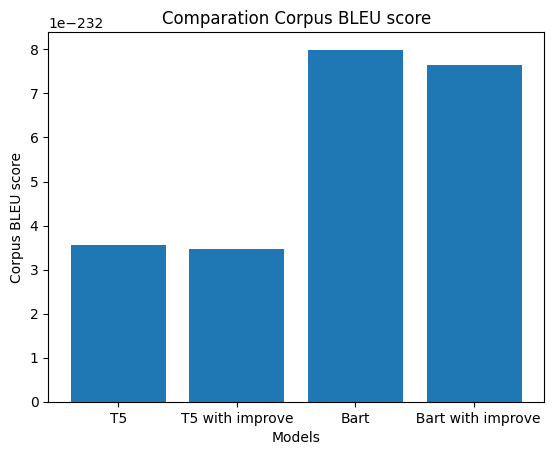

In [ ]:
import matplotlib.pyplot as plt
#corpus bleu
plt.bar(['T5', 'T5 with improve', 'Bart', '  Bart with improve'], [corpus_bleu_T5, corpus_bleu_T5_improve, corpus_bleu_Bart, corpus_bleu_Bart_improve])
plt.xlabel("Models")
plt.ylabel("Corpus BLEU score")
plt.title("Comparation Corpus BLEU score")
plt.show()

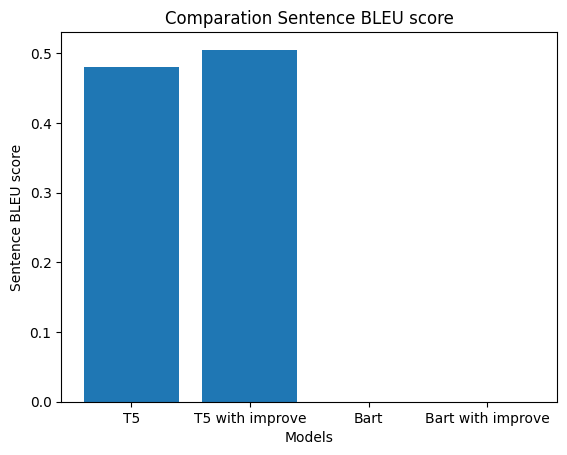

In [ ]:
#corpus bleu
plt.bar(['T5', 'T5 with improve', 'Bart', 'Bart with improve'], [sentence_bleu_T5, sentence_bleu_T5_improve, sentence_bleu_Bart, sentence_bleu_Bart_improve])
plt.xlabel("Models")
plt.ylabel("Sentence BLEU score")
plt.title("Comparation Sentence BLEU score")
plt.show()

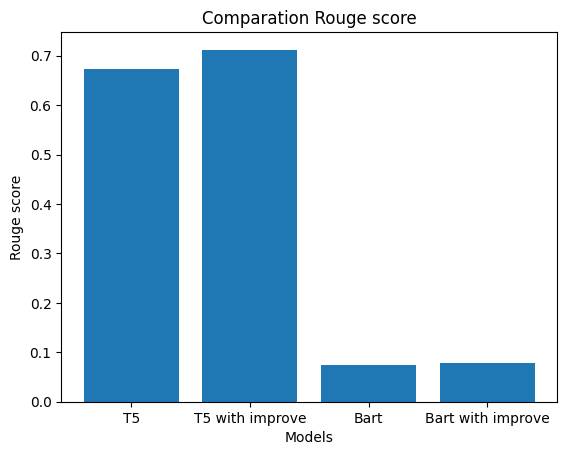

In [ ]:
#corpus bleu
plt.bar(['T5', 'T5 with improve', 'Bart', 'Bart with improve'], [rouge_score_T5, rouge_score_T5_improve, rouge_score_Bart, rouge_score_Bart_improve])
plt.xlabel("Models")
plt.ylabel("Rouge score")
plt.title("Comparation Rouge score")
plt.show()